In [1]:
import numpy as np
import random
import sys
import csv
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

import time
import math
import bottleneck as bn
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd '/content/drive/My Drive/Colab Notebooks/Query Operators'

/content/drive/My Drive/Colab Notebooks/Query Operators


In [4]:
num_iter = 10
hidden_size = 32
num_layers = 1

use_dependency_graph = True

# only one can be set 1
use_embedding = 1
use_linear_reduction = 0
###
atten_decoder = 1
use_dropout = 0
use_average_embedding = 1

weight = 10
labmda = 0
topk_labels = 3

# It should be the same as the reductioned input in decoder's cat function

teacher_forcing_ratio = 0
MAX_LENGTH = 1000
learning_rate = 0.001
optimizer_option = 2
print_val = 100
use_cuda = torch.cuda.is_available()
# use_cuda = True

# print(torch.cuda.get_device_name(0))
# print(torch.cuda.device_count())
print(f"Using cuda: {use_cuda}")

Using cuda: False


In [5]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers, dropout_p=0.2, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        if use_embedding or use_linear_reduction:
            self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
            self.attn1 = nn.Linear(self.hidden_size + output_size, self.hidden_size)
        else:
            self.attn = nn.Linear(self.hidden_size + self.output_size, self.output_size)

        if use_embedding or use_linear_reduction:
            self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
            self.attn_combine3 = nn.Linear(self.hidden_size * 2 + output_size, self.hidden_size)
        else:
            self.attn_combine = nn.Linear(self.hidden_size + self.output_size, self.hidden_size)
        self.attn_combine5 = nn.Linear(self.output_size, self.output_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.reduction = nn.Linear(self.output_size, self.hidden_size)
        if use_embedding or use_linear_reduction:
            self.gru = nn.GRU(hidden_size, hidden_size, num_layers)
        else:
            self.gru = nn.GRU(hidden_size, hidden_size, num_layers)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs, history_record, last_hidden):
        if use_embedding:
            input_list = Variable(torch.LongTensor(input).view(-1, 1))
            if use_cuda:
                input_list = input_list.cuda()
            average_embedding = Variable(torch.zeros(hidden_size)).view(1, 1, -1)
            if use_cuda:
                average_embedding = average_embedding.cuda()

            for ele in input_list:
                embedded = self.embedding(ele).view(1, 1, -1)
                tmp = average_embedding.clone()
                average_embedding = tmp + embedded

            if use_average_embedding:
                tmp = [1] * hidden_size
                length = Variable(torch.FloatTensor(tmp))
                if use_cuda:
                    length = length.cuda()
                # for idx in range(hidden_size):
                real_ave = average_embedding.view(-1) / length
                average_embedding = real_ave.view(1, 1, -1)

            embedding = average_embedding
        else:
            tensorized_input = torch.from_numpy(input).clone().type(torch.FloatTensor)
            inputs = Variable(torch.unsqueeze(tensorized_input, 0).view(1, -1))
            if use_cuda:
                inputs = inputs.cuda()
            if use_linear_reduction == 1:
                reduced_input = self.reduction(inputs)
            else:
                reduced_input = inputs

            embedding = torch.unsqueeze(reduced_input, 0)

        if use_dropout:
            droped_ave_embedded = self.dropout(embedding)
        else:
            droped_ave_embedded = embedding

        history_context = Variable(torch.FloatTensor(history_record).view(1, -1))
        if use_cuda:
            history_context = history_context.cuda()

        attn_weights = F.softmax(
            self.attn(torch.cat((droped_ave_embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        element_attn_weights = F.softmax(
            self.attn1(torch.cat((history_context, hidden[0]), 1)), dim=1)

        # attn_applied = torch.bmm(element_attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))

        # attn_embedd = element_attn_weights * droped_ave_embedded[0]

        output = torch.cat((droped_ave_embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        # output = torch.cat((droped_ave_embedded[0], attn_applied[0], time_coef.unsqueeze(0)), 1)
        # output = self.attn_combine3(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        linear_output = self.out(output[0])
        # output_user_item = F.softmax(linear_output)

        value = torch.sigmoid(self.attn_combine5(history_context).unsqueeze(0))

        one_vec = Variable(torch.ones(self.output_size).view(1, -1))
        if use_cuda:
            one_vec = one_vec.cuda()

        # ones_set = torch.index_select(value[0,0], 1, ones_idx_set[:, 1])
        res = history_context.clone()
        res[history_context != 0] = 1

        output = F.softmax(linear_output * (one_vec - res * value[0]) + history_context * value[0], dim=1)
        # output = F.softmax(linear_output, dim=1)

        return output.view(1, -1), hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(num_layers, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [6]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.reduction = nn.Linear(input_size, hidden_size)
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.time_embedding = nn.Embedding(input_size, hidden_size)
        self.time_weight = nn.Linear(input_size, input_size)
        if use_embedding or use_linear_reduction:
            self.gru = nn.GRU(hidden_size, hidden_size, num_layers)
        else:
            self.gru = nn.GRU(input_size, hidden_size, num_layers)

    def forward(self, input, hidden):
        if use_embedding:
            input_list = Variable(torch.LongTensor(input).view(-1, 1))
            if use_cuda:
                input_list = input_list.cuda()
            average_embedding = Variable(torch.zeros(hidden_size)).view(1, 1, -1)
            # sum_embedding = Variable(torch.zeros(hidden_size)).view(1,1,-1)
            vectorized_input = Variable(torch.zeros(self.input_size)).view(-1)
            if use_cuda:
                average_embedding = average_embedding.cuda()
                # sum_embedding = sum_embedding.cuda()
                vectorized_input = vectorized_input.cuda()

            for ele in input_list:
                embedded = self.embedding(ele).view(1, 1, -1)
                tmp = average_embedding.clone()
                average_embedding = tmp + embedded
                # embedded = self.time_embedding(ele).view(1, 1, -1)
                # tmp = sum_embedding.clone()
                # sum_embedding = tmp + embedded
                vectorized_input[ele] = 1

            # normalize_length = Variable(torch.LongTensor(len(idx_list)))
            # if use_cuda:
            #     normalize_length = normalize_length.cuda()
            if use_average_embedding:
                tmp = [1] * hidden_size
                length = Variable(torch.FloatTensor(tmp))
                if use_cuda:
                    length = length.cuda()
                # for idx in range(hidden_size):
                real_ave = average_embedding.view(-1) / length
                average_embedding = real_ave.view(1, 1, -1)

            embedding = average_embedding
        else:
            tensorized_input = torch.from_numpy(input).clone().type(torch.FloatTensor)
            inputs = Variable(torch.unsqueeze(tensorized_input, 0).view(1, -1))
            if use_cuda:
                inputs = inputs.cuda()
            if use_linear_reduction == 1:
                reduced_input = self.reduction(inputs)
            else:
                reduced_input = inputs

            embedding = torch.unsqueeze(reduced_input, 0)

        output, hidden = self.gru(embedding, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(num_layers, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result


In [7]:
def load_data(path, history_file_name, future_file_name, input_size):
    print("Loading data from disk...")
    freq_max = 200
    X = []
    X_test = []
    X_frequency_init = np.zeros(input_size + 2)

    set_sizes = []
    
    with open(path + "data/" + history_file_name, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        prevQueryId = currentQueryId = None
        tmp = []
        for i, row in enumerate(reader):
            if i == 0:
                prevQueryId = currentQueryId = row['queryId']
            currentQueryId = row['queryId']
            if currentQueryId != prevQueryId:
                X.append(np.sort(tmp))
                set_sizes.append(len(tmp))
                tmp = []
            tmp.append(int(row['partialQEPId']))
            
            

            prevQueryId = currentQueryId
    
    print("X first 100:", X[:100])
    print("X last 100:", X[-100:])

    with open(path + "data/" + future_file_name, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        prevQueryId = currentQueryId = None
        tmp = []
        for i, row in enumerate(reader):
            if i == 0:
                prevQueryId = currentQueryId = row['queryId']
            currentQueryId = row['queryId']
            if currentQueryId != prevQueryId:
                X_test.append(np.sort(tmp))
                set_sizes.append(len(tmp))
                tmp = []
            tmp.append(int(row['partialQEPId']))
            prevQueryId = currentQueryId
    print("X_test first 100:", X_test[:100])
    print("X_test last 100:", X_test[-100:])


    print("Maximum set size:", max(set_sizes))
    print("Average set size:", np.mean(set_sizes))


    from scipy.stats import norm

    # Fit a normal distribution to the data:
    mu, std = norm.fit(set_sizes)

    # Plot the histogram.
    plt.hist(set_sizes, bins=25, alpha=0.6, density=True, color='blue')
    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.xlabel('Set size')
    plt.ylabel('Frequency') 
    plt.xticks(list(range(1, 21)))
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)
    plt.show()


    return X, X_test, input_size + 2, X_frequency_init


def load_dependency_graph(path, filename):
    graph = {}
    with open(path + "data/" + filename, mode='r') as csvfile:
        reader = csv.DictReader(csvfile, quotechar='"', delimiter=';')
        for row in reader:
            if len(row['impliedPartialQEPs']) > 0:
                graph[row['partialQEP']] = [int(s) for s in row['impliedPartialQEPs'].split(',')]
            else:
                graph[row['partialQEP']] = []
    return graph


def load_costs(path, filename):
    comptime, rowcount, sizes = {}, {}, {}
    with open(path + "data/" + filename, mode='r') as csvfile:
        reader = csv.DictReader(csvfile, quotechar='"', delimiter=';')
        for row in reader:
            comptime[row['partialQEPId']] = int(row['computationTime'])
            rowcount[row['partialQEPId']] = int(row['rowCount'])
            sizes[row['partialQEPId']] = int(row['byteSize'])
    return comptime, rowcount, sizes

def get_frequency_vector(X, X_dim):
    result_vector = np.zeros(X_dim, dtype=int)
    for i in X:
        result_vector[i] += 1
    return result_vector


def sliding_windows(X, seq_length, next_k_step):
    X_train = []
    y_train = []

    for i in range(len(X)-(seq_length+next_k_step)):
        _X_train = [[-1], *X[i:(i+seq_length)]]
        _y_train = [[-1], *X[(i+seq_length):(i+seq_length+next_k_step)]]
        _X_train.append([-1])
        _y_train.append([-1])
        X_train.append(_X_train)
        y_train.append(_y_train)

    return X_train, y_train

def sample_pairs(input_sequence, seq_length, next_k_step, n_pairs):
    X = []
    y = []
    for _ in range(n_pairs):
        idx = random.randint(0, len(input_sequence) - (seq_length + next_k_step))
        X.append([[-1], *input_sequence[idx:idx + seq_length], [-1]])
        y.append([[-1], *input_sequence[idx + seq_length:idx + seq_length + next_k_step], [-1]])
    return X, y

In [8]:
class Node:
    def __init__(self, id, comp, size, rows):
        self.id = id
        self.comp = comp
        self.size = size
        self.rows = rows
        self.prev = None
        self.next = None
    def __str__(self):
        return f"id={self.id}, comp_time={self.comp}, byte_size={self.size}, row_count={self.rows}"

class LRUCache:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory_used = 0
        self.dic = dict()
        self.head = Node(0, 0, 0, 0)
        self.tail = Node(0, 0, 0, 0)
        self.head.next = self.tail
        self.tail.prev = self.head

    def print_cachetype(self):
        print("LRU cache")

    def print_cache(self):
        print("Cache: {")
        for v in self.dic.values():
            print(v)
        print("}")

    def evict_non_predictions(self, predicted_ids):
        for key in self.dic.keys():
            if key not in predicted_ids:
                print("Evicting:", self.dic[key])
                self._remove(self.dic[key])
                del self.dic[key]

    def get(self, id):
        if id in self.dic:
            n = self.dic[id]
            self._remove(n)
            self._add(n)
            return n
        return None

    def put(self, id, comp, size, rows, dont_evict_ids=[]):
        if size > self.capacity:
            print(f"Too big for memory! id={id}, comp_time={comp}, byte_size={size}, row_count={rows}")
            return
        if id in self.dic:
            self._remove(self.dic[id])
        n = Node(id, comp, size, rows)
        self._add(n)
        # print("Adding:", n)
        self.dic[id] = n
        while self.memory_used > self.capacity:
            n = self.head.next
            print("Evicting:", n)
            self._remove(n)
            del self.dic[n.id]
            # Add it back in front if we predicted it
            if n.id in dont_evict_ids and not (all(key in dont_evict_ids for key in self.dic.keys())):
                self._add(n)
                self.dic[n.id] = n

    def _remove(self, node):
        self.memory_used -= node.size
        p = node.prev
        n = node.next
        p.next = n
        n.prev = p

    def _add(self, node):
        self.memory_used += node.size
        p = self.tail.prev
        p.next = node
        self.tail.prev = node
        node.prev = p
        node.next = self.tail


class FIFOCache:
    def __init__(self, capacity):
        self.capacity = capacity 
        self.memory_used = 0
        self.dic = dict()
        self.head = Node(0, 0, 0, 0)
        self.tail = Node(0, 0, 0, 0)
        self.head.next = self.tail
        self.tail.prev = self.head
    
    def print_cachetype(self):
        print("FIFO cache")

    def print_cache(self):
        print("Cache: {")
        for v in self.dic.values():
            print(v)
        print("}")

    def get(self, id):
        if id in self.dic:
            n = self.dic[id]
            return n
        return None

    def put(self, id, comp, size, rows, dont_evict_ids=[]):
        if size > self.capacity:
            print(f"Too big for memory! id={id}, comp_time={comp}, byte_size={size}, row_count={rows}")
            return
        if id in self.dic:
            return
        n = Node(id, comp, size, rows)
        self._add(n)
        # print("Adding:", n)
        self.dic[id] = n
        while self.memory_used > self.capacity:
            n = self.head.next
            print("Evicting:", n)
            self._remove(n)
            del self.dic[n.id]
            # Add it back in front if we predicted it
            if n.id in dont_evict_ids and not (all(key in dont_evict_ids for key in self.dic.keys())):
                self._add(n)
                self.dic[n.id] = n

    def _remove(self, node):
        self.memory_used -= node.size
        p = node.prev
        n = node.next
        p.next = n
        n.prev = p

    def _add(self, node):
        self.memory_used += node.size
        p = self.tail.prev
        p.next = node
        self.tail.prev = node
        node.prev = p
        node.next = self.tail

In [9]:
def decoding_next_k_step(encoder, decoder, input_variable, output_size, k, num_set_elements, implied_elements):
    encoder_hidden = encoder.initHidden()

    input_length = len(input_variable)
    encoder_outputs = Variable(torch.zeros(MAX_LENGTH, encoder.hidden_size))
    if use_cuda:
        encoder_outputs = encoder_outputs.cuda()

    loss = 0

    history_record = np.zeros(output_size)
    count = 0
    for ei in range(input_length - 1):
        if ei == 0:
            continue
        for ele in input_variable[ei]:
            history_record[ele] += 1
        count += 1

    history_record = history_record / count

    for ei in range(input_length - 1):
        if ei == 0:
            continue
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei - 1] = encoder_output[0][0]


    decoder_input = input_variable[input_length - 2]

    decoder_hidden = encoder_hidden
    last_hidden = decoder_hidden
    # Without teacher forcing: use its own predictions as the next input
    num_str = 0
    topk = 400
    decoded_vectors = []
    prob_vectors = []
    cout = 0
    for di in range(k):
        if atten_decoder:
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs, history_record, last_hidden)
        else:
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
        topv, topi = decoder_output.data.topk(topk)
        ni = topi[0][0]

        count = 0
        start_idx = -1
        end_idx = output_size
        pick_num = num_set_elements

        tmp = []
        for ele in range(len(topi[0])):
            if count >= pick_num:
                break
            tmp.append(topi[0][ele])
            count += 1

        res = []
        for i, ele in enumerate(tmp):
            res.append(ele)
            if i < len(tmp) and use_dependency_graph:
                implicit_elements = implied_elements[str(ele.item())]
                for impl_ele in implicit_elements:
                    t = torch.LongTensor([impl_ele]).squeeze()
                    if use_cuda:
                        t = t.cuda()
                    res.append(t)

        decoded_vectors.append(res)
        decoder_input = res
        
        res2 = []
        for i in range(topk):
            res2.append(topi[0][i])
        prob_vectors.append(res2)

    return decoded_vectors, prob_vectors

In [10]:

def generate_predictions(windows, encoder_instance, decoder_instance, X_dim, next_k_step, implied_elements):
    input_sequences = []
    predicted_sequences = []
    for iter, input_variable in enumerate(windows):
        print("\r" +'Prediction iter ', iter+1, ' out of ', len(windows), "(" + str(int((iter+1) / len(windows) * 100)) + "%)" ,end="") if (iter+1) % 100 == 0 else 0
           
        input_sequences.append(input_variable[1:-1])
        # print("input", input_variable[1:-1])
        output_vectors, prob_vectors = decoding_next_k_step(encoder_instance, decoder_instance, input_variable,
                                                            X_dim, next_k_step, 5, implied_elements)
        
        output_variable = []
        for idx in range(len(output_vectors)):
            pred_set = set([int(t.item()) for t in output_vectors[idx]])
            output_variable.append(np.array(list(pred_set)))
        # print("prediction", output_variable)
        predicted_sequences.append(output_variable)
    
    with open('./data/iot_output_input_sequences_test.npy', 'wb') as f:
        np.save(f, np.array(input_sequences))
    with open('./data/iot_output_predicted_sequences_test.npy', 'wb') as f:
        np.save(f, np.array(predicted_sequences))

def find_topmost_plan_id(query, implied_elements, debug=False):
    seen_elements = set()
    for query_id in query:
        elements = implied_elements[str(query_id)]
        print(query_id, "=>", elements)
        for element in elements:
            seen_elements.add(element)
    for query_id in query:
        if query_id not in seen_elements:
            # print("Topmost Id:", query_id)
            return query_id

def find_topmost_plan_ids(query, implied_elements):
    seen_elements = set()
    ids = []
    for query_id in query:
        elements = implied_elements[str(query_id)]
        print(query_id, "=>", elements)
        for element in elements:
            seen_elements.add(element)
    for query_id in query:
        if query_id not in seen_elements:
            # print("Topmost Id:", query_id)
            ids.append(query_id)
    return ids

def limit_to_memory(predicted_ids, sizes, capacity):
    predicted_id_sizes = []
    for id in predicted_ids:
        predicted_id_sizes.append(sizes[str(id)])
    if sum(predicted_id_sizes) <= capacity:
        return predicted_ids
    sorted_ids = sorted(zip(predicted_id_sizes, predicted_ids))
    while sum([t[0] for t in sorted_ids]) > capacity:
        sorted_ids.pop()
    return [t[1] for t in sorted_ids]


def evaluate_model_precompute(X, input_sequences, predicted_sequences, implied_elements, comptime, sizes, rowcount, capacity):
    computation_times = []
    optimized_computation_times = []
    time_saved = 0
    for index, query in enumerate(X):
        print(f"{index}/{len(X)}")
        print("Query:", query)
        # print(input_sequences[index + 1])
        topmost_plan_id = find_topmost_plan_id(query, implied_elements)
        query_computation_time = comptime[str(topmost_plan_id)]
        print("Comptime:", query_computation_time)
        computation_times.append(query_computation_time)

        # find the partial QEP ids that are precomputed
        print("Prediction:", predicted_sequences[index])
        predicted_ids = np.array(predicted_sequences[index])
        
        # flatten 2 sequential sets
        predicted_ids = list(set(np.hstack(predicted_ids)))

        # use first set only
        # predicted_ids = predicted_ids[0]

        # pre-compute next 2 sets, but keep in memory up to a number
        predicted_ids = limit_to_memory(predicted_ids, sizes, capacity)

        predicted_ids = [id for id in predicted_ids if id in query]

        top_most_plan_ids = find_topmost_plan_ids(predicted_ids, implied_elements)

        query_optimized_time = query_computation_time
        for id in top_most_plan_ids:
            print(f"Cache hit for id {id}, saves {comptime[str(id)]} ms")
            query_optimized_time -= comptime[str(id)]
        query_optimized_time = max(query_optimized_time, 0)
        print("Optimized comptime:", query_optimized_time)
        optimized_computation_times.append(query_optimized_time)
        time_saved += query_computation_time - query_optimized_time
    print("=== Results ===")
    print(f"Total comp time: {sum(computation_times)} ms")
    print(f"Optimized comp time: {sum(optimized_computation_times)} ms")
    print(f"Total time saved: {time_saved} ms")
    print(f"Speedup: {round(sum(computation_times) / sum(optimized_computation_times), 2)}x")

    return sum(computation_times), sum(optimized_computation_times), round(sum(optimized_computation_times) / len(X) , 2), round(sum(computation_times) / sum(optimized_computation_times), 2)

def evaluate_cache(X, implied_elements, comptime, sizes, rowcount, CacheType, capacity):
    cache = CacheType(capacity)
    computation_times = []
    optimized_computation_times = []
    time_saved = 0
    for index, query in enumerate(X):
        print(f"{index}/{len(X)}")
        print("Query:", query)
        topmost_plan_id = find_topmost_plan_id(query, implied_elements)
        query_computation_time = comptime[str(topmost_plan_id)]
        print("Comptime:", query_computation_time)
        computation_times.append(query_computation_time)

        # find the partial QEP ids that are cached, then subtract the top most plans
        cached_ids = []
        for id in query:
            if cache.get(id) is not None:
                cached_ids.append(id)

        top_most_plan_ids = find_topmost_plan_ids(cached_ids, implied_elements)

        query_optimized_time = query_computation_time
        for id in top_most_plan_ids:
            print(f"Cache hit for id {id}, saves {comptime[str(id)]} ms")
            query_optimized_time -= comptime[str(id)]
        query_optimized_time = max(query_optimized_time, 0)
        print("Optimized comptime:", query_optimized_time)
        optimized_computation_times.append(query_optimized_time)
        time_saved += query_computation_time - query_optimized_time
        # put each partial QEP in the cache
        for id in query:
            cache.put(id, comptime[str(id)], sizes[str(id)], rowcount[str(id)])
    cache.print_cachetype()
    print("=== Results ===")
    print(f"Total comp time: {sum(computation_times)} ms")
    print(f"Optimized comp time: {sum(optimized_computation_times)} ms")
    print(f"Total time saved: {time_saved} ms")
    print(f"Speedup: {round(sum(computation_times) / sum(optimized_computation_times), 2)}x")

    return sum(computation_times), sum(optimized_computation_times), round(sum(optimized_computation_times) / len(X), 2), round(sum(computation_times) / sum(optimized_computation_times), 2)

    

def evaluate_cache_with_predictions(X, input_sequences, predicted_sequences, implied_elements, comptime, sizes, rowcount, capacity, CacheType):
    computation_times = []
    optimized_computation_times = []
    cache = CacheType(capacity)
    time_saved = 0
    for index, query in enumerate(X):
        print(f"{index}/{len(X)}")
        print("Query:", query)
        # print(input_sequences[index + 1])
        topmost_plan_id = find_topmost_plan_id(query, implied_elements)
        query_computation_time = comptime[str(topmost_plan_id)]
        print("Comptime:", query_computation_time)
        computation_times.append(query_computation_time)

        # find the partial QEP ids that are predicted
        print("Prediction:", predicted_sequences[index])
        predicted_ids = np.array(predicted_sequences[index])
        
        # flatten 2 sequential sets
        predicted_ids = list(set(np.hstack(predicted_ids)))

        cached_ids = []
        for id in query:
            if cache.get(id) is not None:
                cached_ids.append(id)

        top_most_plan_ids = find_topmost_plan_ids(cached_ids, implied_elements)

        query_optimized_time = query_computation_time
        for id in top_most_plan_ids:
            print(f"Cache hit for id {id}, saves {comptime[str(id)]} ms")
            query_optimized_time -= comptime[str(id)]
        query_optimized_time = max(query_optimized_time, 0)
        print("Optimized comptime:", query_optimized_time)
        optimized_computation_times.append(query_optimized_time)
        time_saved += query_computation_time - query_optimized_time
        # put each partial QEP in the cache
        for id in query:
            cache.put(id, comptime[str(id)], sizes[str(id)], rowcount[str(id)], predicted_ids)

    print(f"Total comp time: {sum(computation_times)} ms")
    print(f"Optimized comp time: {sum(optimized_computation_times)} ms")
    print(f"Total time saved: {time_saved} ms")
    print(f"Speedup: {round(sum(computation_times) / sum(optimized_computation_times), 2)}x")

    return sum(computation_times), sum(optimized_computation_times), round(sum(optimized_computation_times) / len(X), 2), round(sum(computation_times) / sum(optimized_computation_times), 2)


In [11]:
def main():
    history_file_name, future_file_name = ['iot_output_first80percent_6000.csv', 'iot_output_last20percent_6000.csv']
    graph_file_name = "iot_output_dependency_graph_6000.csv"
    cost_file_name = "iot_output_comptime_100000rows_6000.csv"
    model_version = '_iot_0.001_new'
    dict_size = 5800
    
    path = './'
    directory = './models/'
    
    seq_length = 20 # length of the input sequences we train on
    next_k_step = 2 # next k steps to predict
    n_training_pairs = 20000 # number of training pairs
    n_testing_pairs = 5000 # number of testing pairs
    num_set_elements_validation = 5 # number of set elements to predict for validaiton set during training

    generate_predictions = False

    if not os.path.exists(directory):
        os.makedirs(directory)

    # print(torch.cuda.get_device_name(0))
    print("Files:", history_file_name, future_file_name)
    print("Seq_length: " + str(seq_length) +", Next_k_step: " + str(next_k_step))
    print("Training pairs: " + str(n_training_pairs) + ", Testing pairs: " + str(n_testing_pairs))
    
    X, X_future, X_dim, X_frequency_init = load_data(path, history_file_name, future_file_name, dict_size)
    
    implied_elements = load_dependency_graph(path, graph_file_name)
    print("Dependencies:", implied_elements)

    comptime, rowcount, sizes = load_costs(path, cost_file_name)


    for i in range(20):
        print(str(i+1), "Comptime:", comptime[str(i+1)], "Rowcount:", rowcount[str(i+1)], "Sizes:", sizes[str(i+1)])


    for id, duration in comptime.items():
        if len(implied_elements[str(id)]) == 0:
            io_speed = 100000 # B/ms
            io_duration = int(round(sizes[str(id)] / io_speed))
            comptime[str(id)] += io_duration
            print(id, io_duration)
            for id2 in comptime.keys():
                if id in implied_elements[str(id2)]:
                    comptime[str(id2)] += io_duration
        

    X_freq = get_frequency_vector(X, X_dim)
    print("X_freq:", X_freq)
    print("X_dim:", X_dim)

    weights = np.zeros(X_dim)
    max_freq = max(X_freq)
    
    print('Maximum feature frequency:', max_freq)
    for i in range(len(X_freq)):
        if X_freq[i] > 0:
            weights[i] = max_freq / X_freq[i]
        else:
            weights[i] = 0

    print("Weights:", weights)


    print("Average of row count:", np.mean(list(rowcount.values()))) 
    print("Min, max of row count:", min(list(rowcount.values())), max(list(rowcount.values()))) 
    print("Average of comp time:", np.mean(list(comptime.values()))) 
    print("Min, max of comp time:", min(list(comptime.values())), max(list(comptime.values())))
    print("Average of byte sizes:", np.mean(list(sizes.values()))) 
    print("Min, max of byte sizes:", min(list(sizes.values())), max(list(sizes.values()))) 
    print("Sum of byte sizes:", sum(list(sizes.values())))
    print("Number of queries:", len(X_future))


    if generate_predictions:
        windows, _ = sliding_windows(X_future, 20, 2)

        model_epoch = 2
        encoder_pathes = './models/encoder' + str(model_version) + '_model_epoch' + str(model_epoch)
        decoder_pathes = './models/decoder' + str(model_version) + '_model_epoch' + str(model_epoch)

        encoder_instance = torch.load(encoder_pathes)
        decoder_instance = torch.load(decoder_pathes)
        generate_predictions(windows, encoder_instance, decoder_instance, X_dim, next_k_step, implied_elements)
    else:
        input_sequences = []
        predicted_sequences = []

        with open('./data/iot_output_input_sequences_test.npy', 'rb') as f:
            input_sequences = np.load(f,  allow_pickle=True)


        with open('./data/iot_output_predicted_sequences_test.npy', 'rb') as f:
            predicted_sequences = np.load(f,  allow_pickle=True)


        for i in range (20):
            print("input", input_sequences[i])
            print("pred", predicted_sequences[i])

        # Size of a table is roughly 25MB, hence we dont use more memory
        # capacity = 104857600 # 100MB
        # capacity = 78643200 # 75MB
        # capacity = 52428800 # 50MB
        # capacity = 26214400 # 25MB



        times_25 = []
        avg_times_25 = []
        speedups_25 = []

        times_50 = []
        avg_times_50 = []
        speedups_50 = []

        times_75 = []
        avg_times_75 = []
        speedups_75 = []

        times_100 = []
        avg_times_100 = []
        speedups_100 = []


        # for i, capacity in enumerate([26214400, 52428800, 78643200, 104857600]):
        for i, capacity in enumerate([78643200, 104857600]):

            times = []
            avg_times = []
            speedups = []

            print(len(X_future))
            

            computation_time_sum, optimized_time_sum, optimized_time_avg, speedup = evaluate_cache(X_future, implied_elements, comptime, sizes, rowcount, LRUCache, capacity)

            #none
            times.append(computation_time_sum)
            avg_times.append(0)
            speedups.append(1.00)
            
            #LRU
            times.append(optimized_time_sum)
            avg_times.append(optimized_time_avg)
            speedups.append(speedup)

            #FIFO
            computation_time_sum, optimized_time_sum, optimized_time_avg, speedup = evaluate_cache(X_future, implied_elements, comptime, sizes, rowcount, FIFOCache, capacity)
            times.append(optimized_time_sum)
            avg_times.append(optimized_time_avg)
            speedups.append(speedup)

            computation_time_sum, optimized_time_sum, optimized_time_avg, speedup = evaluate_cache_with_predictions(X_future[20:-5], input_sequences, predicted_sequences, implied_elements, comptime, sizes, rowcount, capacity, LRUCache)
            times.append(optimized_time_sum)
            avg_times.append(optimized_time_avg)
            speedups.append(speedup)

            computation_time_sum, optimized_time_sum, optimized_time_avg, speedup = evaluate_cache_with_predictions(X_future[20:-5], input_sequences, predicted_sequences, implied_elements, comptime, sizes, rowcount, capacity, FIFOCache)
            times.append(optimized_time_sum)
            avg_times.append(optimized_time_avg)
            speedups.append(speedup)

            computation_time_sum, optimized_time_sum, optimized_time_avg, speedup = evaluate_model_precompute(X_future[20:-5], input_sequences, predicted_sequences, implied_elements, comptime, sizes, rowcount, capacity)
            times[0] = computation_time_sum
            times.append(optimized_time_sum)
            avg_times.append(optimized_time_avg)
            speedups.append(speedup)

            # if i == 0:
            #     times_25 = times
            #     avg_times_25 = avg_times
            #     speedups_25 = speedups
            # if i == 1:
            #     times_50 = times
            #     avg_times_50 = avg_times
            #     speedups_50 = speedups
            if i == 0:
                times_75 = times
                avg_times_75 = avg_times
                speedups_75 = speedups
            if i == 1:
                times_100 = times
                avg_times_100 = avg_times
                speedups_100 = speedups


        d = {'time': times_25, 'avg_time': avg_times_25, 'speedup': speedups_25, 'time2': times_50, 'avg_time2': avg_times_50, 'speedup2': speedups_50}
        df = pd.DataFrame(data=d)
        print(df.to_latex(index=False))

        d = {'time': times_75, 'avg_time': avg_times_75, 'speedup': speedups_75, 'time2': times_100, 'avg_time2': avg_times_100, 'speedup2': speedups_100}
        df = pd.DataFrame(data=d)
        print(df.to_latex(index=False))



Files: iot_output_first80percent_6000.csv iot_output_last20percent_6000.csv
Seq_length: 20, Next_k_step: 2
Training pairs: 20000, Testing pairs: 5000
Loading data from disk...
X first 100: [array([ 44, 145]), array([ 44, 145]), array([ 44, 145]), array([ 44, 145]), array([ 44, 145]), array([ 44, 145]), array([ 44, 145]), array([ 44, 145]), array([ 44, 145]), array([2, 3]), array([2, 3]), array([2, 3]), array([2, 3]), array([2, 3]), array([7, 9]), array([   1,   62,   78, 3797]), array([  6,  84,  86, 982]), array([ 1, 10, 31, 62, 85]), array([   8,   76,   77, 4981]), array([   8,   76,   77, 1016]), array([  8,  76,  77, 683]), array([   8,   76,   77, 3159]), array([   8,   76,   77, 3150]), array([2, 3]), array([2, 3]), array([2, 3]), array([7, 9]), array([   1,   62,   78, 1876]), array([   6,   84,   86, 5783]), array([ 1, 10, 31, 62, 85]), array([   8,   76,   77, 1731]), array([   8,   76,   77, 2353]), array([   8,   76,   77, 4754]), array([   8,   76,   77, 4243]), array([   

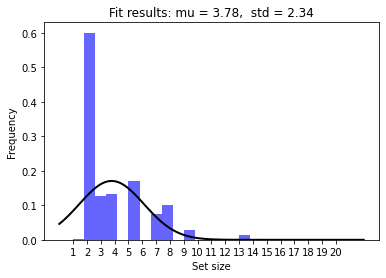

Dependencies: {'3672': [42, 41, 30], '3331': [42, 41, 30], '2990': [77, 76, 8], '5538': [77, 76, 8], '5197': [42, 41, 30], '3744': [42, 41, 30], '3026': [42, 41, 30], '5233': [42, 41, 30], '3340': [42, 41, 30], '2685': [42, 41, 30], '5547': [42, 41, 30], '2344': [42, 41, 30], '4892': [78, 62, 1], '5206': [42, 41, 30], '4551': [42, 41, 30], '4865': [42, 41, 30], '5646': [42, 41, 30], '3753': [42, 41, 30], '5305': [77, 76, 8], '5619': [42, 41, 30], '4964': [42, 41, 30], '2353': [77, 76, 8], '5278': [42, 41, 30], '4560': [42, 41, 30], '2012': [42, 41, 30], '137': [59], '3107': [77, 76, 8], '5314': [42, 41, 30], '5628': [77, 76, 8], '4973': [42, 41, 30], '5287': [78, 62, 1], '4632': [42, 41, 30], '2021': [42, 41, 30], '4946': [115, 2808, 120, 125, 121, 116, 1, 109, 124, 2, 118, 113, 7, 108, 112, 114, 30, 111, 122], '4291': [78, 62, 1], '4228': [77, 76, 8], '891': [84, 86, 6], '1205': [78, 62, 1], '550': [42, 41, 30], '146': [5, 37, 147, 43, 36], '864': [42, 41, 30], '2775': [77, 76, 8], '4

KeyboardInterrupt: ignored

In [12]:
main()